In [1]:
import pandas as pd
import pickle
import networkx as nx
import numpy as np
import geopandas as gpd
import json

from shapely.geometry import  MultiLineString, mapping, shape
from matplotlib import pyplot as plt
from tqdm import tqdm

# 1. EDA of XD segments & TMC segments (in cranberry shapefile, PA shapefile and tmc speed file)

### 1.1  File I/O

In [5]:
# read files as pandas/geopandas dataframes
spd_tmc = pd.read_csv("../../data/cranberry_tmc_5min/manually_select_cranberry_2019_dont_average_2/TMC_Identification.csv")  # features of unique 1248 tmc segments covered in tmc speed data; shape (1248, 39)

# spd_tmc contains the speed data of tmc segments, and only covers 195 tmc segments in our craberry shapefile
gpdf_xd_cranberry = gpd.read_file("../../data/shape/xd_shape_cranberry/v1/xd_cranberry_for_sjoin.geojson")  # features of 556 unique xd segments manually selected from PA shape file through QGIS; shape (556, 25)
gpdf_tmc_cranberry = gpd.read_file("../../data/shape/tmc_shape_cranberry/v1/tmc_cranberry.geojson")  # id and geometry of 315 unique tmc segments in cranberry shape file, 195 of which are covered in "spd_tmc"; shape (331, 2) 

# gpdf_tmc_PA = gpd.read_file("../../data/shapefiles/tmc_shape_PA/Pennsylvania.shp") # features of 16041 unique tmc segments, 1233 of which are covered "spd_tmc", contains 195 segments shared by "spd_tmc" and "gpdf_tmc_cranberry"; shape (16041, 37)

In [6]:
spd_tmc.head(5)

,tmc,road,direction,intersection,state,county,zip,start_latitude,start_longitude,end_latitude,...,aadt_singl,aadt_combi,nhs,nhs_pct,strhnt_typ,strhnt_pct,truck,isprimary,active_start_date,active_end_date
0,104N09100,PENN AVE,WESTBOUND,PA-380/PENN CIR W/S EUCLID AVE,PA,ALLEGHENY,15206,40.46252,-79.92785,40.46275,...,705,61,1,100,0,100,0,1,2019-01-01 00:00:00-05:00,2020-01-01 00:00:00-05:00
1,104-09238,5TH AVE,WESTBOUND,BLUE BELT/SHADY AVE,PA,ALLEGHENY,15206,40.45400,-79.91237,40.45289,...,1111,46,1,100,0,100,0,1,2019-01-01 00:00:00-05:00,2020-01-01 00:00:00-05:00
2,104-09239,PA-8,WESTBOUND,PA-380/PA-8/PENN AVE,PA,ALLEGHENY,15208,40.45831,-79.90829,40.45400,...,939,176,1,100,0,100,0,1,2019-01-01 00:00:00-05:00,2020-01-01 00:00:00-05:00
3,104-09236,5TH AVE,WESTBOUND,BELLEFIELD AVE,PA,ALLEGHENY,15213,40.44781,-79.93722,40.44653,...,686,22,1,78,0,0,0,1,2019-01-01 00:00:00-05:00,2020-01-01 00:00:00-05:00
4,104-09237,5TH AVE,WESTBOUND,WILKINS AVE,PA,ALLEGHENY,15232,40.45289,-79.92074,40.44781,...,794,405,1,94,0,0,0,1,2019-01-01 00:00:00-05:00,2020-01-01 00:00:00-05:00


In [7]:
gpdf_xd_cranberry.head(5)

,OID,XDSegID,PreviousXD,NextXDSegI,FRC,RoadNumber,RoadName,LinearID,Country,State,...,SpecialRoa,RoadList,StartLat,StartLong,EndLat,EndLong,Bearing,XDGroup,ShapeSRID,geometry
0,None,132112962,None,None,4,None,Duncan Avenue,None,United States,Pennsylvania,...,None,Duncan Avenue,40.56849,-80.02401,40.56869,-80.02644,W,441098,4326,"MULTILINESTRING ((-80.02401 40.56849, -80.0242..."
1,None,132158129,1310596942,134453381,2,None,Duncan Avenue,None,United States,Pennsylvania,...,None,Duncan Avenue,40.56717,-80.01648,40.56847,-80.02383,W,441098,4326,"MULTILINESTRING ((-80.01648 40.56717, -80.0166..."
2,None,132403172,None,None,4,None,Mennonite Lane,None,United States,Pennsylvania,...,None,"Mennonite Lane,US 19",40.80928,-80.12924,40.80937,-80.12941,W,449088,4326,"MULTILINESTRING ((-80.12924 40.80928, -80.1292..."
3,None,132873381,None,132544667,3,None,Thorn Hill Road,None,United States,Pennsylvania,...,None,Thorn Hill Road,40.66731,-80.09635,40.66731,-80.09651,W,463412,4326,"MULTILINESTRING ((-80.09635 40.66731, -80.0965..."
4,None,132883695,None,None,2,None,Duncan Avenue,None,United States,Pennsylvania,...,None,Duncan Avenue,40.56849,-80.02401,40.56847,-80.02383,E,463726,4326,"MULTILINESTRING ((-80.02401 40.56849, -80.0238..."


In [206]:
gpdf_tmc_cranberry.head(5)

,id,geometry
0,104P06676,"MULTILINESTRING ((-80.09178 40.68545, -80.0926..."
1,104P06676,"MULTILINESTRING ((-80.09390 40.68532, -80.0944..."
2,104N06676,"MULTILINESTRING ((-80.09645 40.68532, -80.0960..."
3,104P04742,"MULTILINESTRING ((-80.10045 40.68140, -80.1003..."
4,104P11608,"MULTILINESTRING ((-80.09590 40.68212, -80.0958..."


### 1.2 Visualization

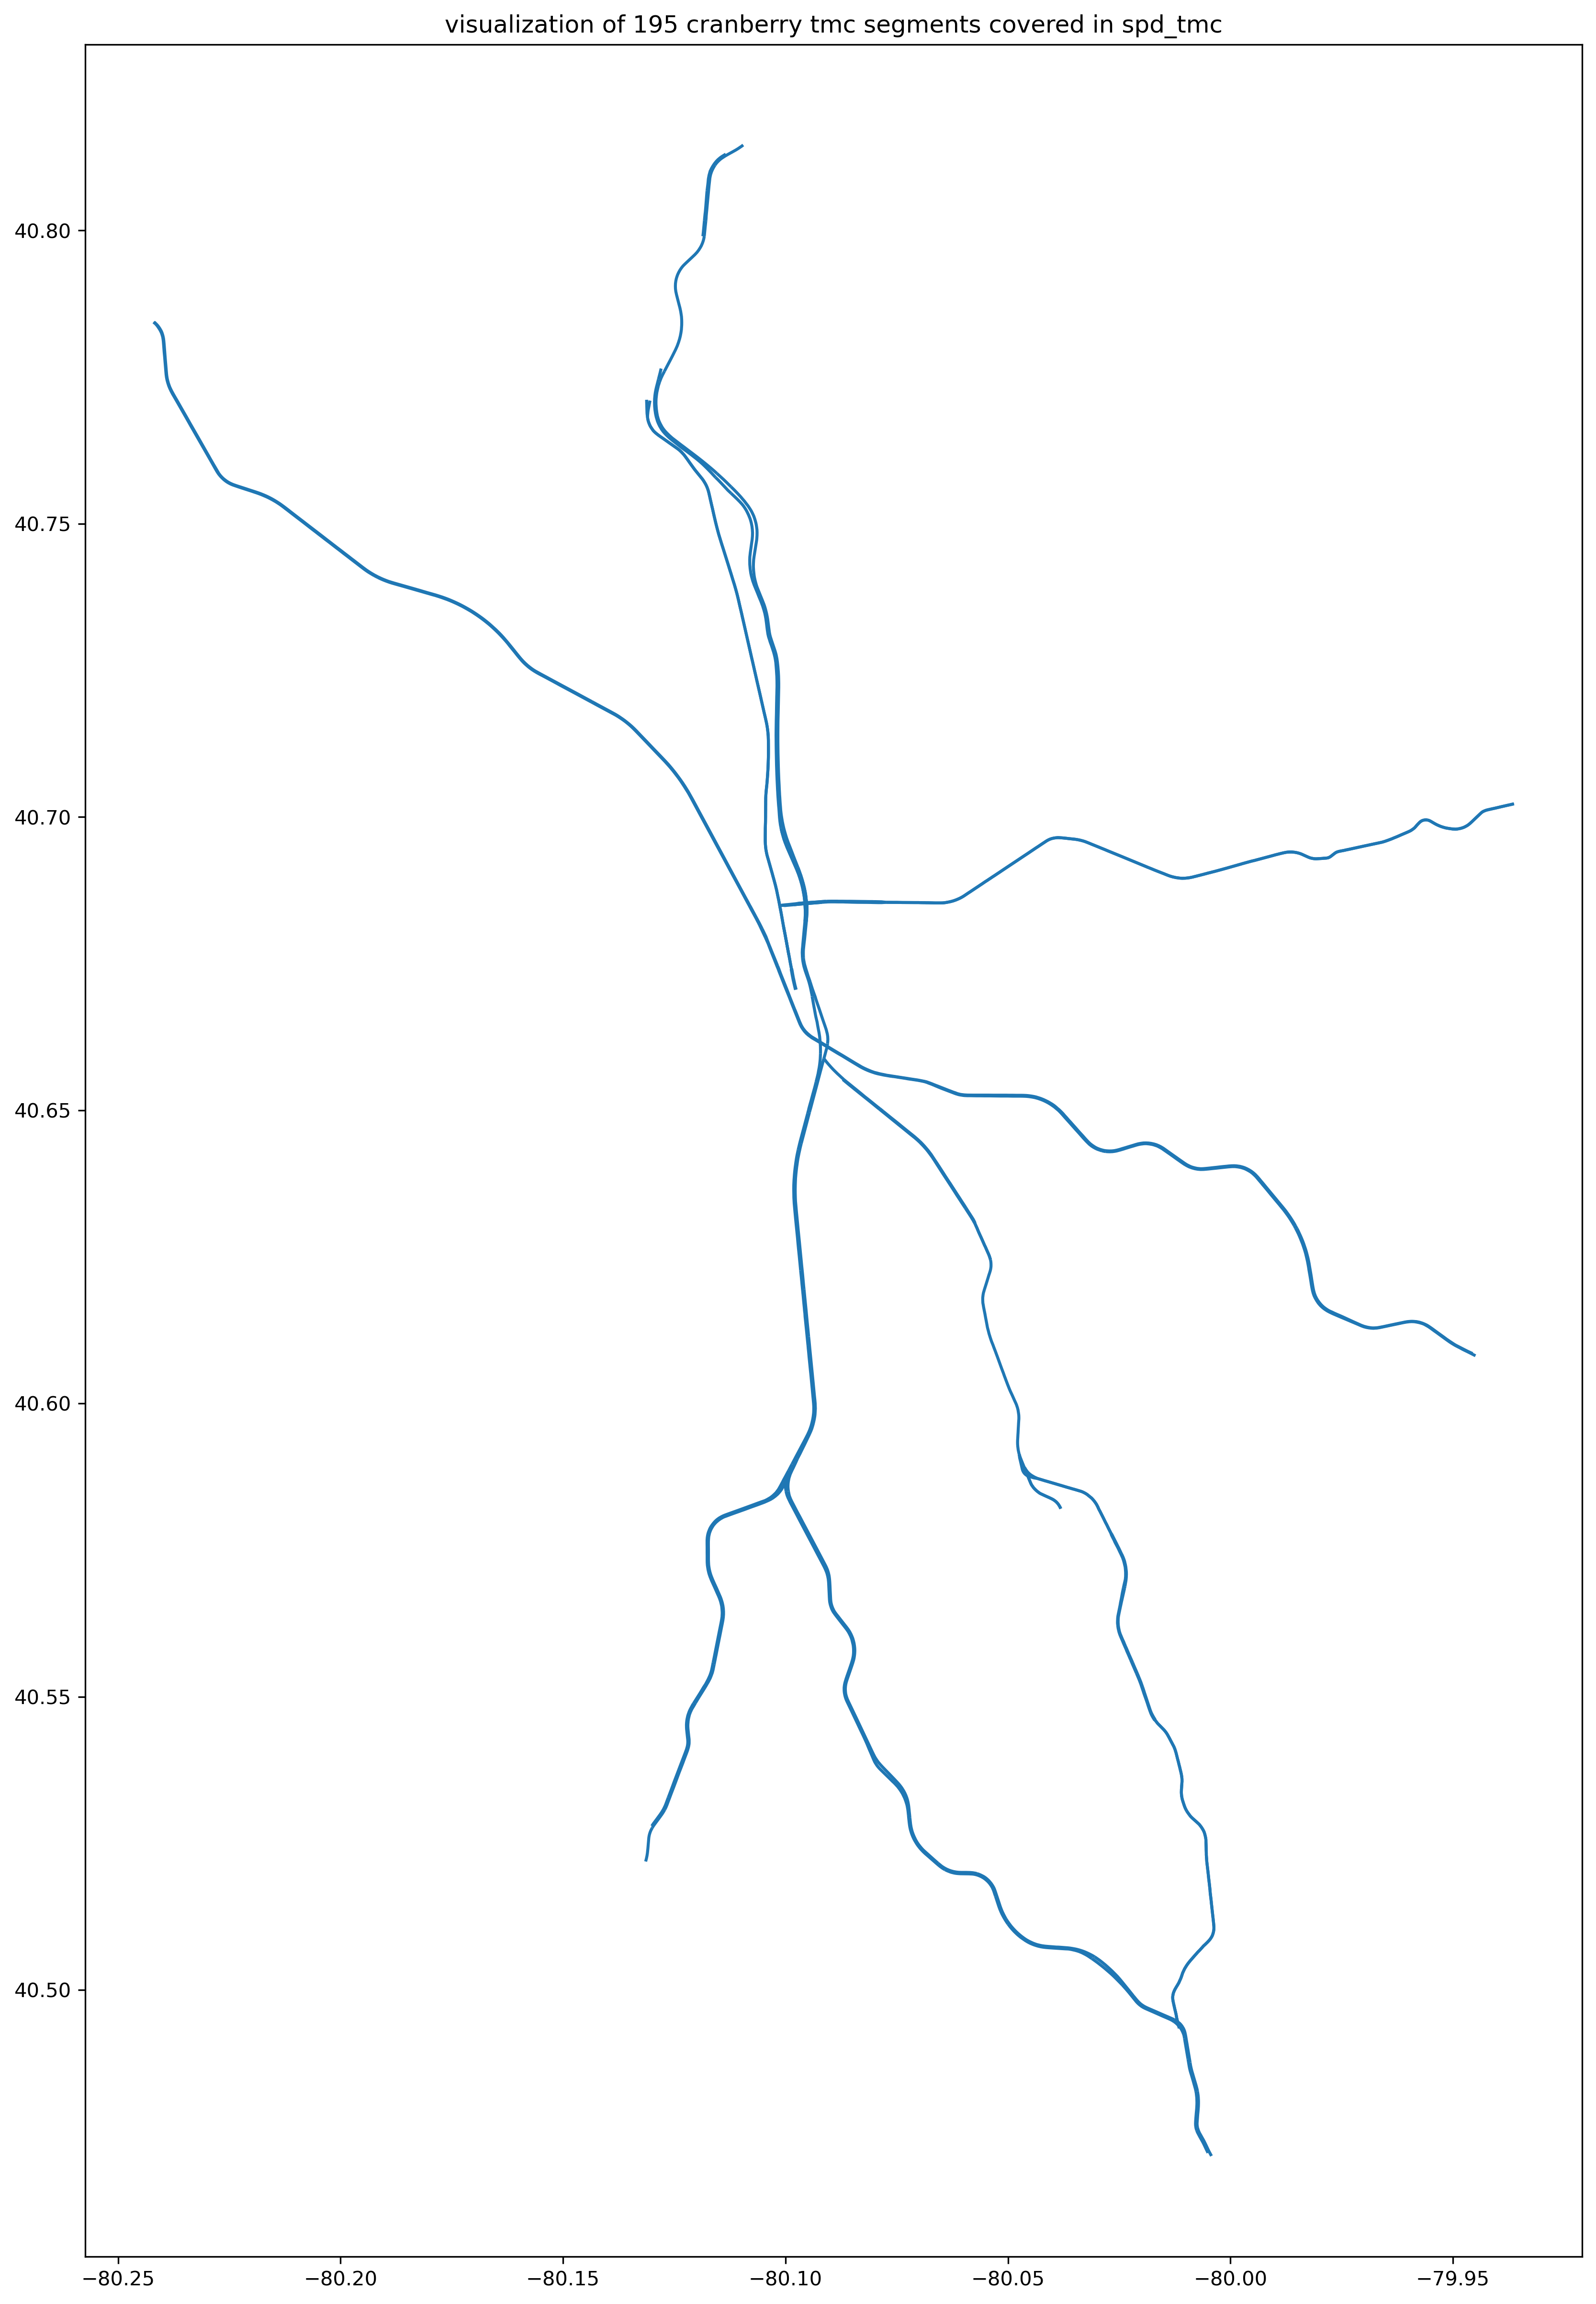

In [8]:
# (1) visualization of 195 cranberry tmc segments covered in spd_tmc
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
ax.set_title("visualization of 195 cranberry tmc segments covered in spd_tmc")
gpdf_tmc_cranberry[gpdf_tmc_cranberry.id.isin(set(spd_tmc.tmc))].plot(ax=ax)
fig.savefig("./viz_gpdf_tmc_cranberry_195.jpg")

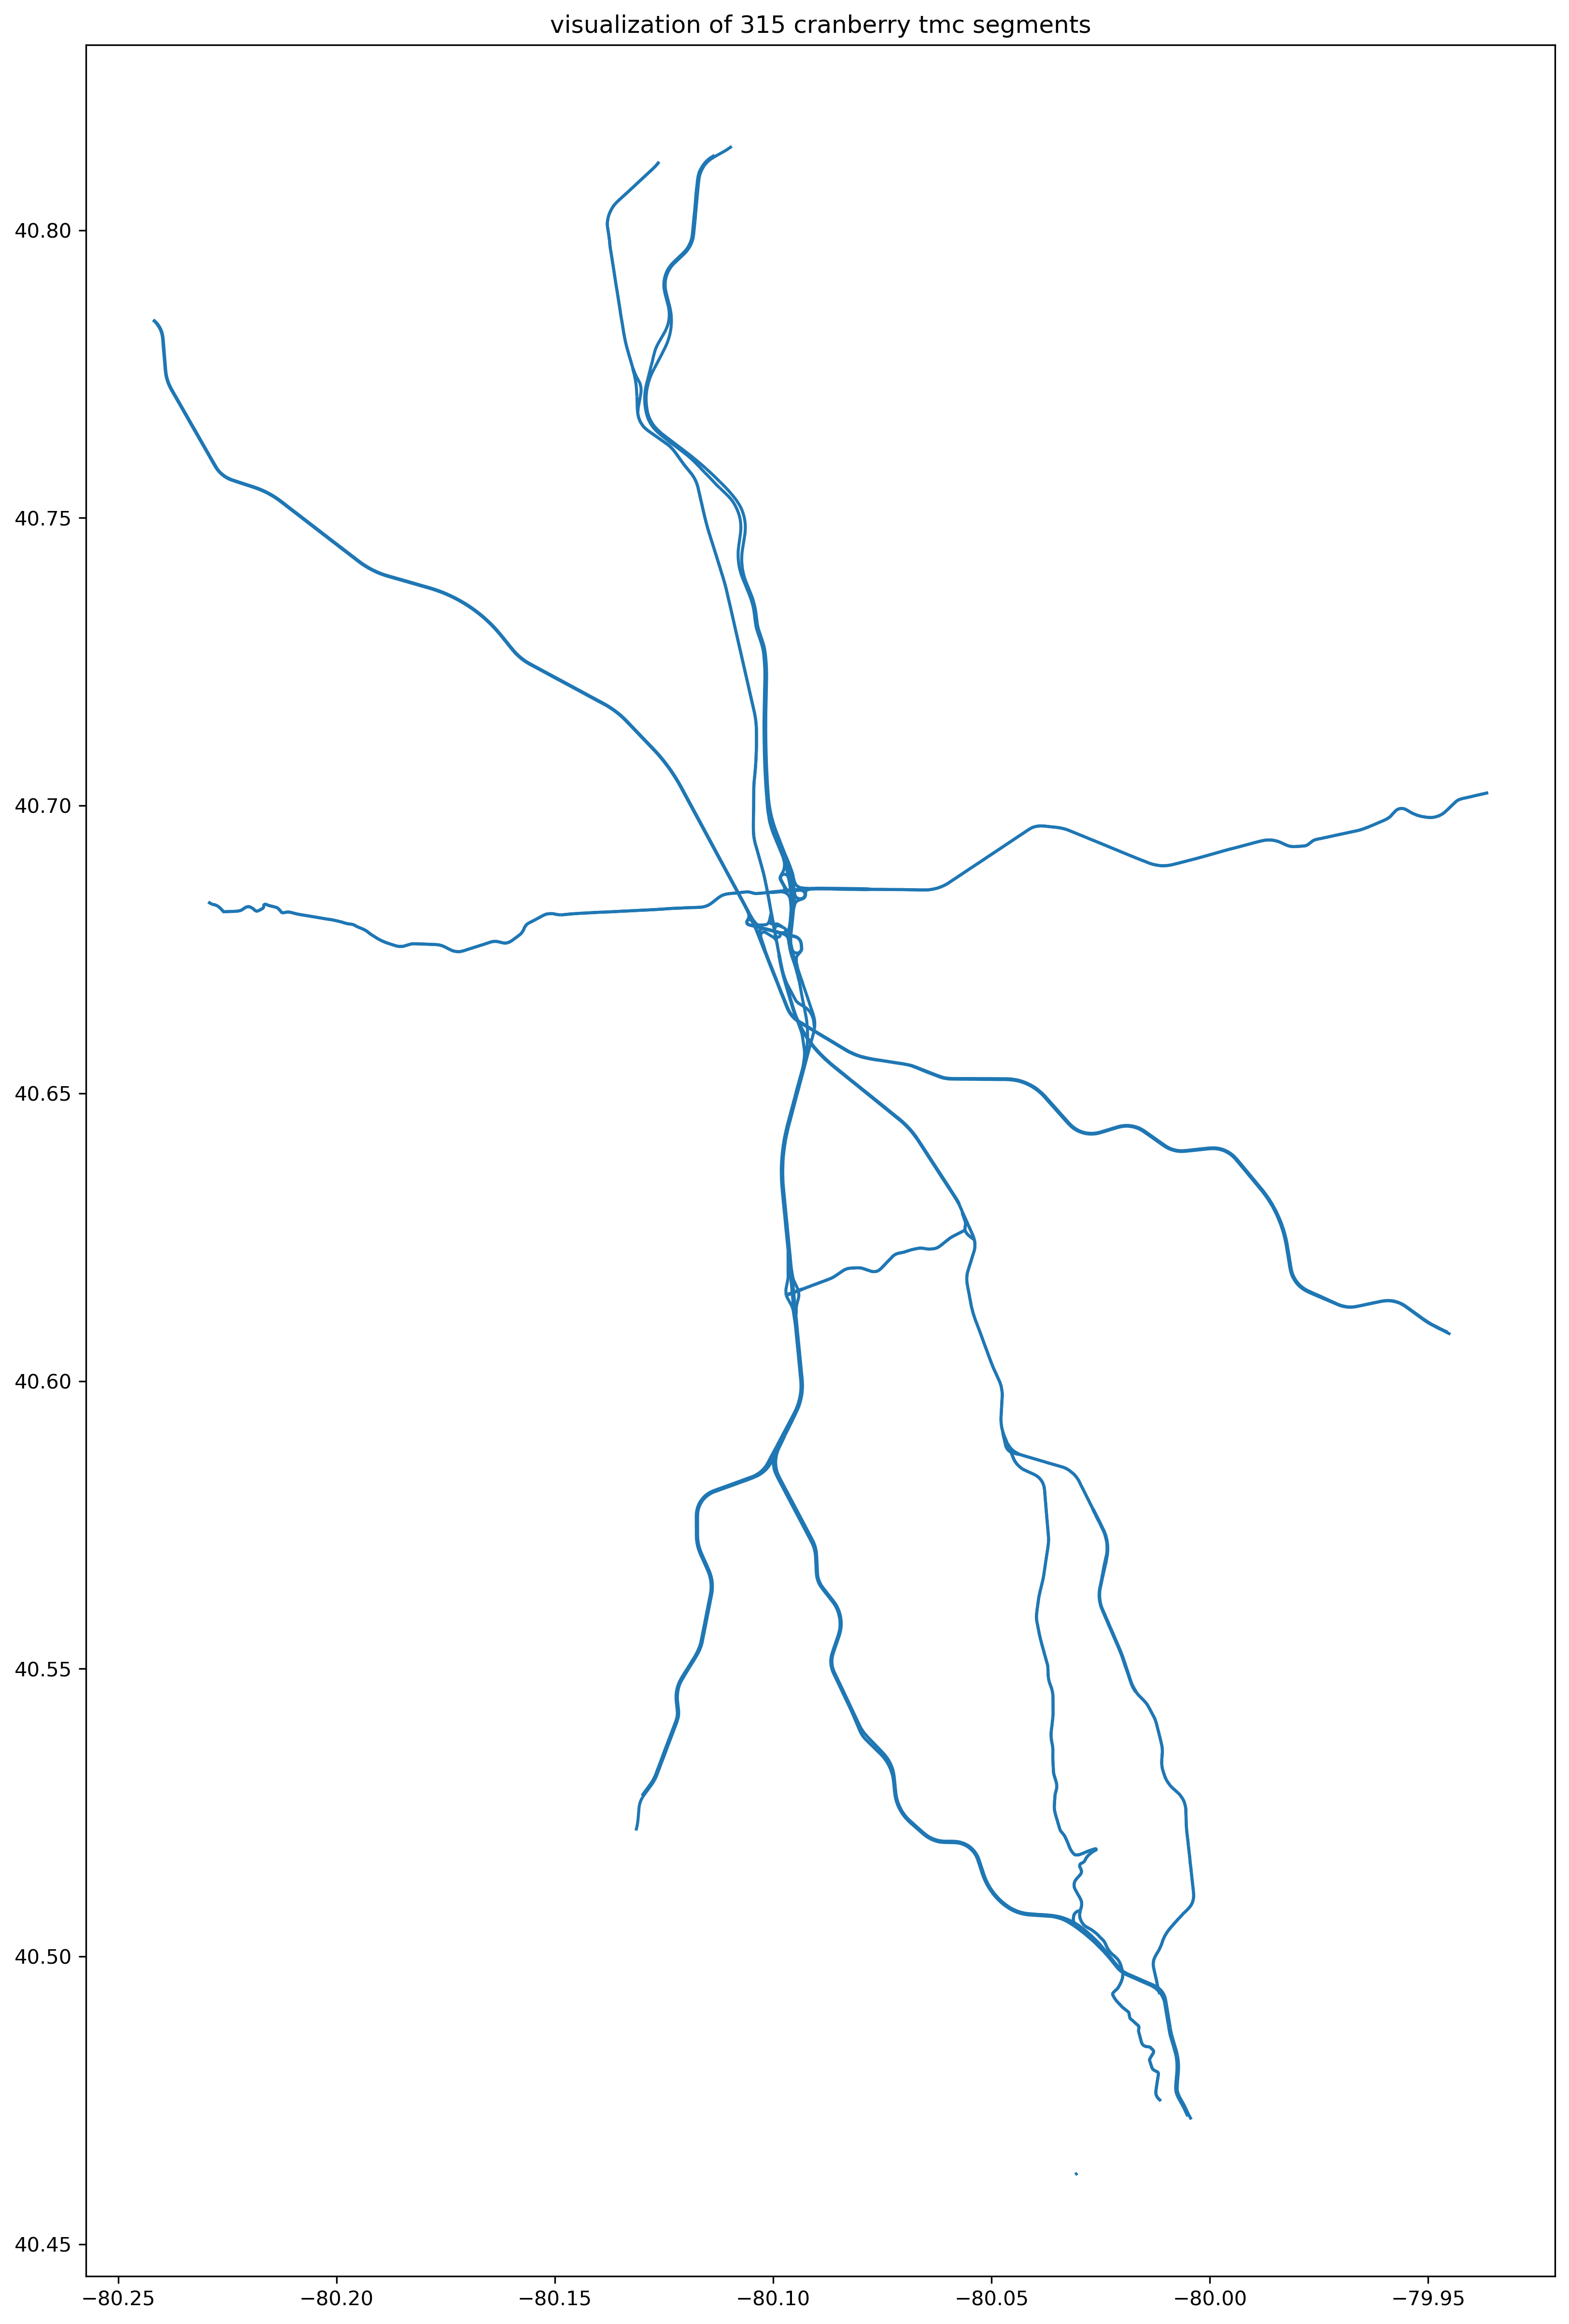

In [9]:
# (2) visualization of 315 cranberry tmc segments 
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
ax.set_title("visualization of 315 cranberry tmc segments")
gpdf_tmc_cranberry.plot(ax=ax)
fig.savefig("./viz_gpdf_tmc_cranberry_315.jpg")

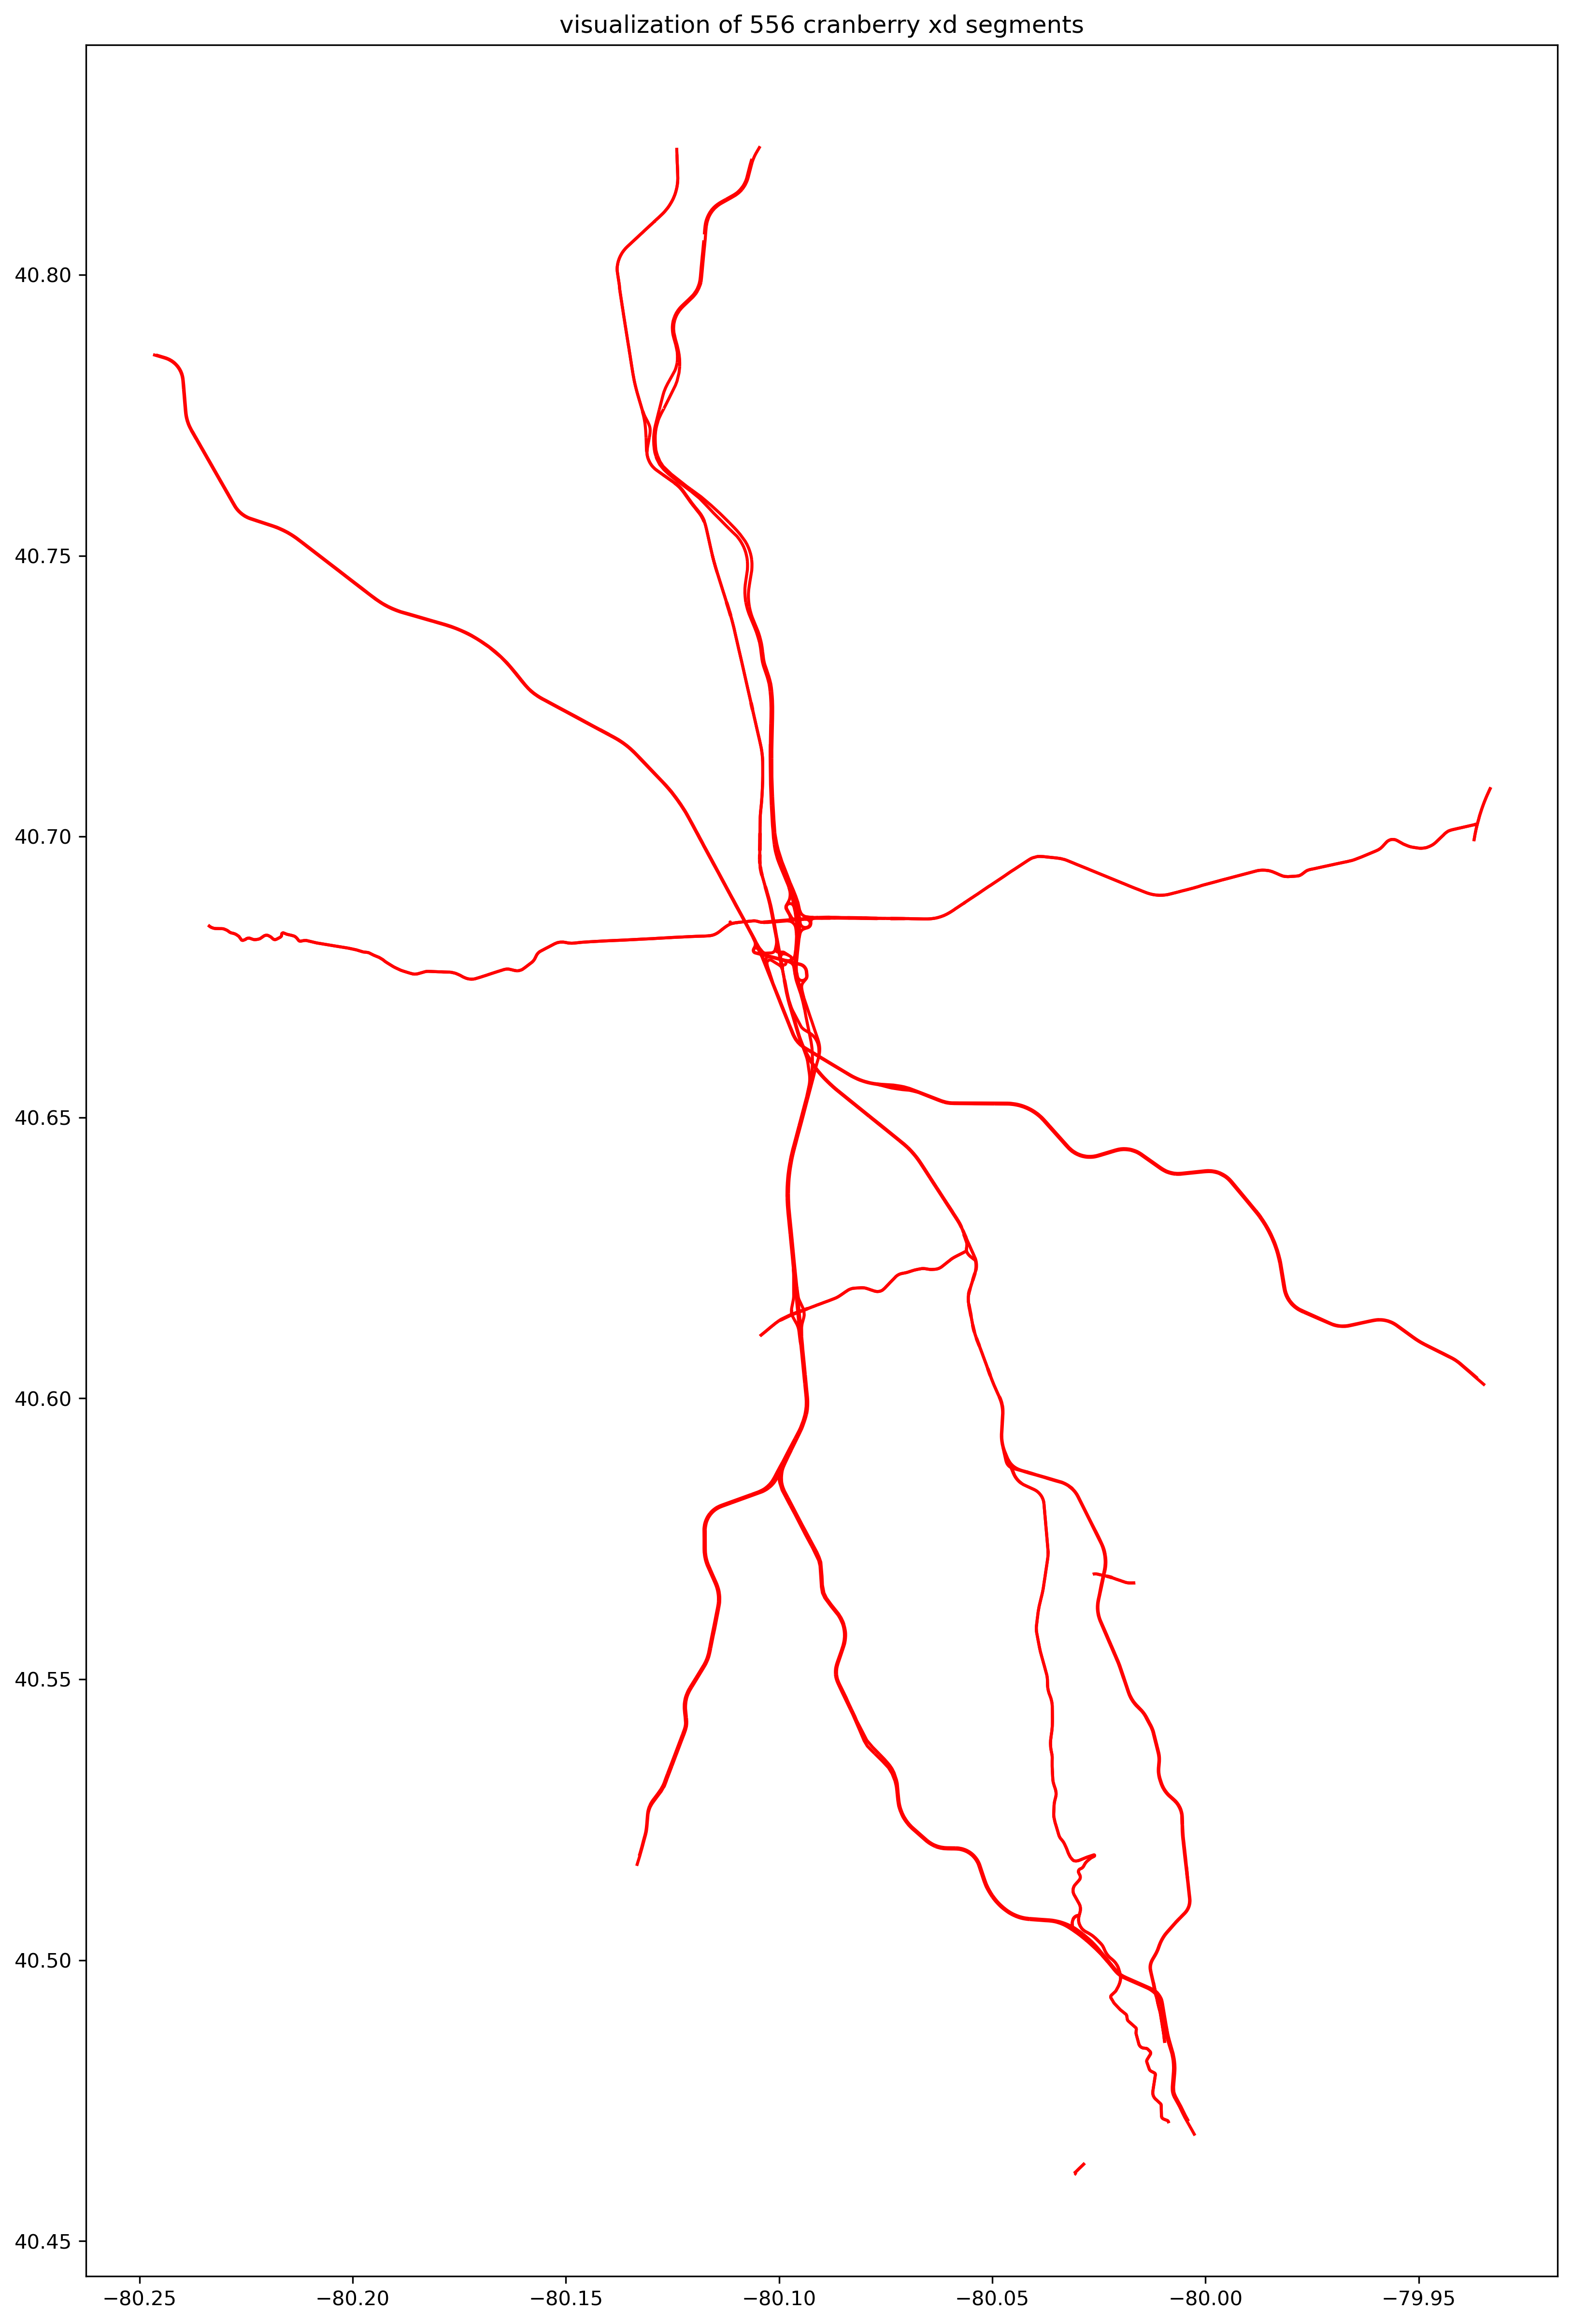

In [10]:
# (3) visualization of 556 cranberry xd segments 
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
ax.set_title("visualization of 556 cranberry xd segments")
gpdf_xd_cranberry.plot(ax=ax, color="red")
fig.savefig("./viz_gpdf_xd_cranberry.jpg")

# 2. Match TMC and XD Segments

### 2.1 Create Buffer for Segments
Since the geometry of TMC segments and those of XD segments may not be perfectly aligned with one another, i.e. there may well be a tiny gap/shift between a TMC-XD pair even though they are supposed to be matched, here a buffer is created for each segment. The size of buffer ("distance" as specified in syntax of geopandas function) is manually defined. 

In [11]:
gpdf_tmc_cranberry_polygon = gpdf_tmc_cranberry.copy()
gpdf_tmc_cranberry_polygon["geometry"] = gpdf_tmc_cranberry.to_crs(epsg=3857).buffer(distance=10, resolution=1).to_crs(epsg=4326)

gpdf_xd_cranberry_polygon = gpdf_xd_cranberry.copy()
gpdf_xd_cranberry_polygon["geometry"] = gpdf_xd_cranberry.to_crs(epsg=3857).buffer(distance=10, resolution=1).to_crs(epsg=4326)

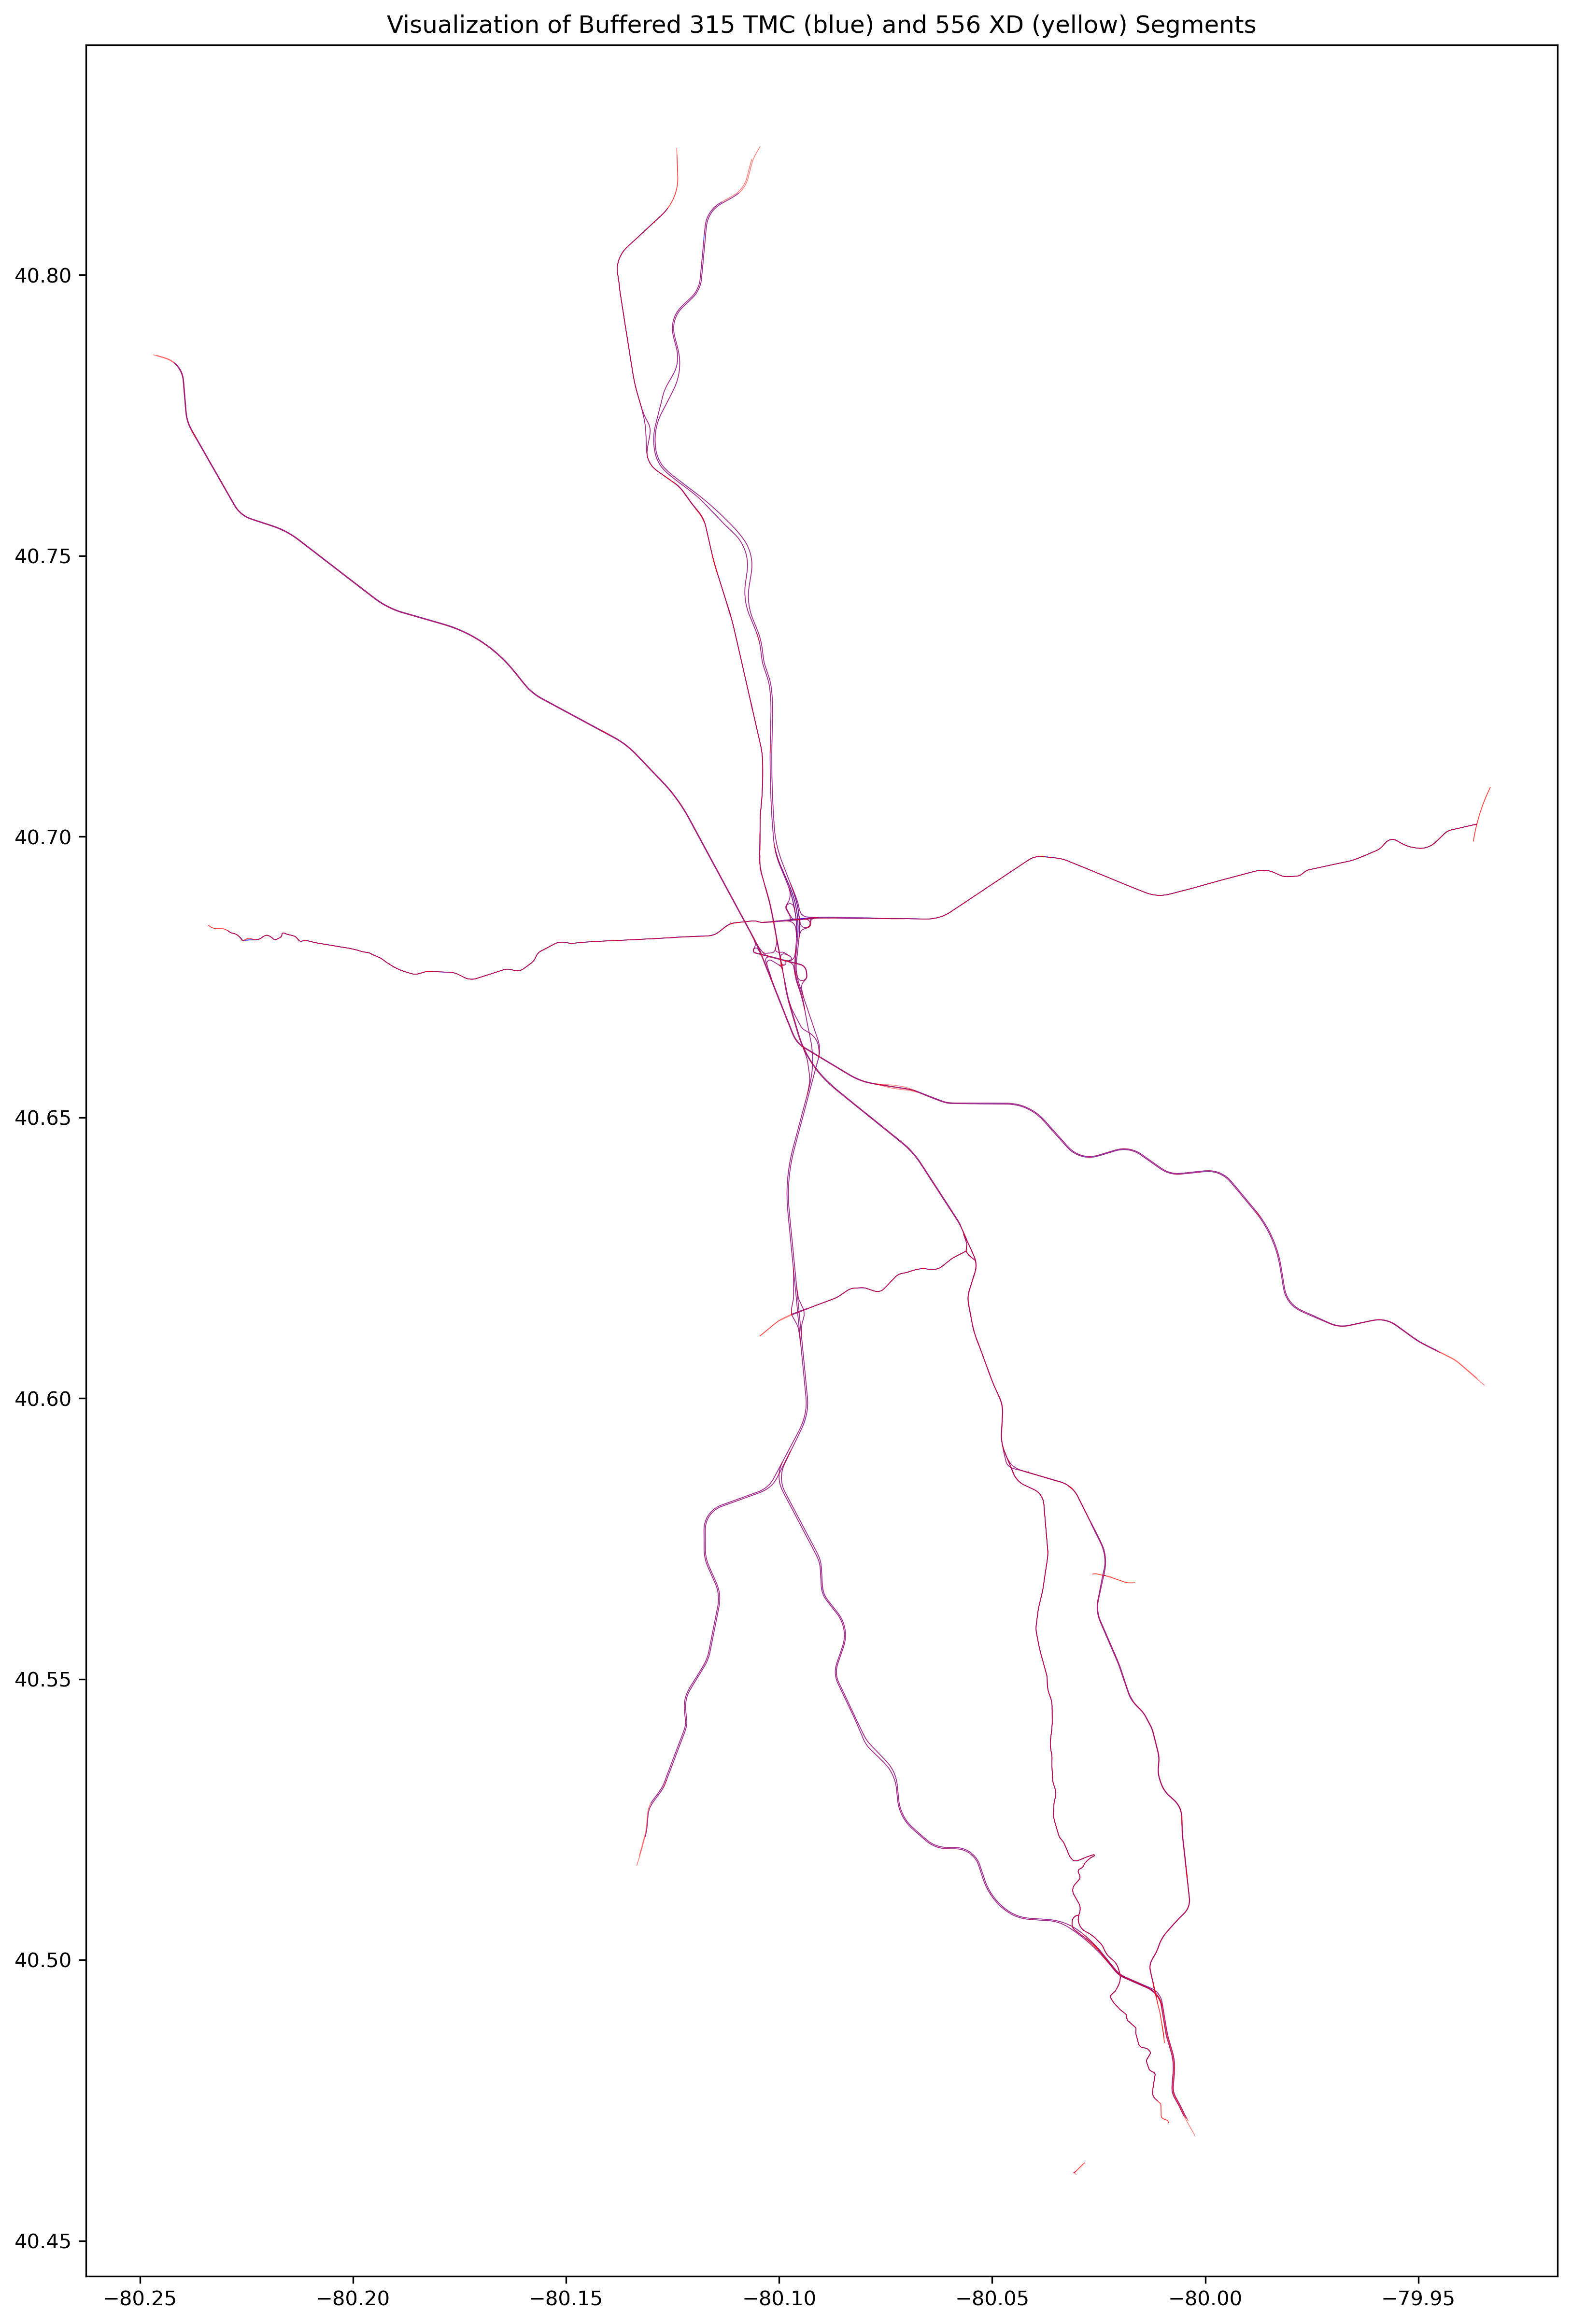

In [15]:
# Visualization of Buffered 315 TMC (blue) and 556 XD (yellow) Segments
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
ax.set_title("Visualization of Buffered 315 TMC (blue) and 556 XD (yellow) Segments")
gpdf_tmc_cranberry_polygon.plot(ax=ax, color="blue", alpha=0.7)
gpdf_xd_cranberry_polygon.plot(ax=ax, color="red", alpha=0.5)
fig.savefig("./viz_buffered_tmc315_xd.jpg")

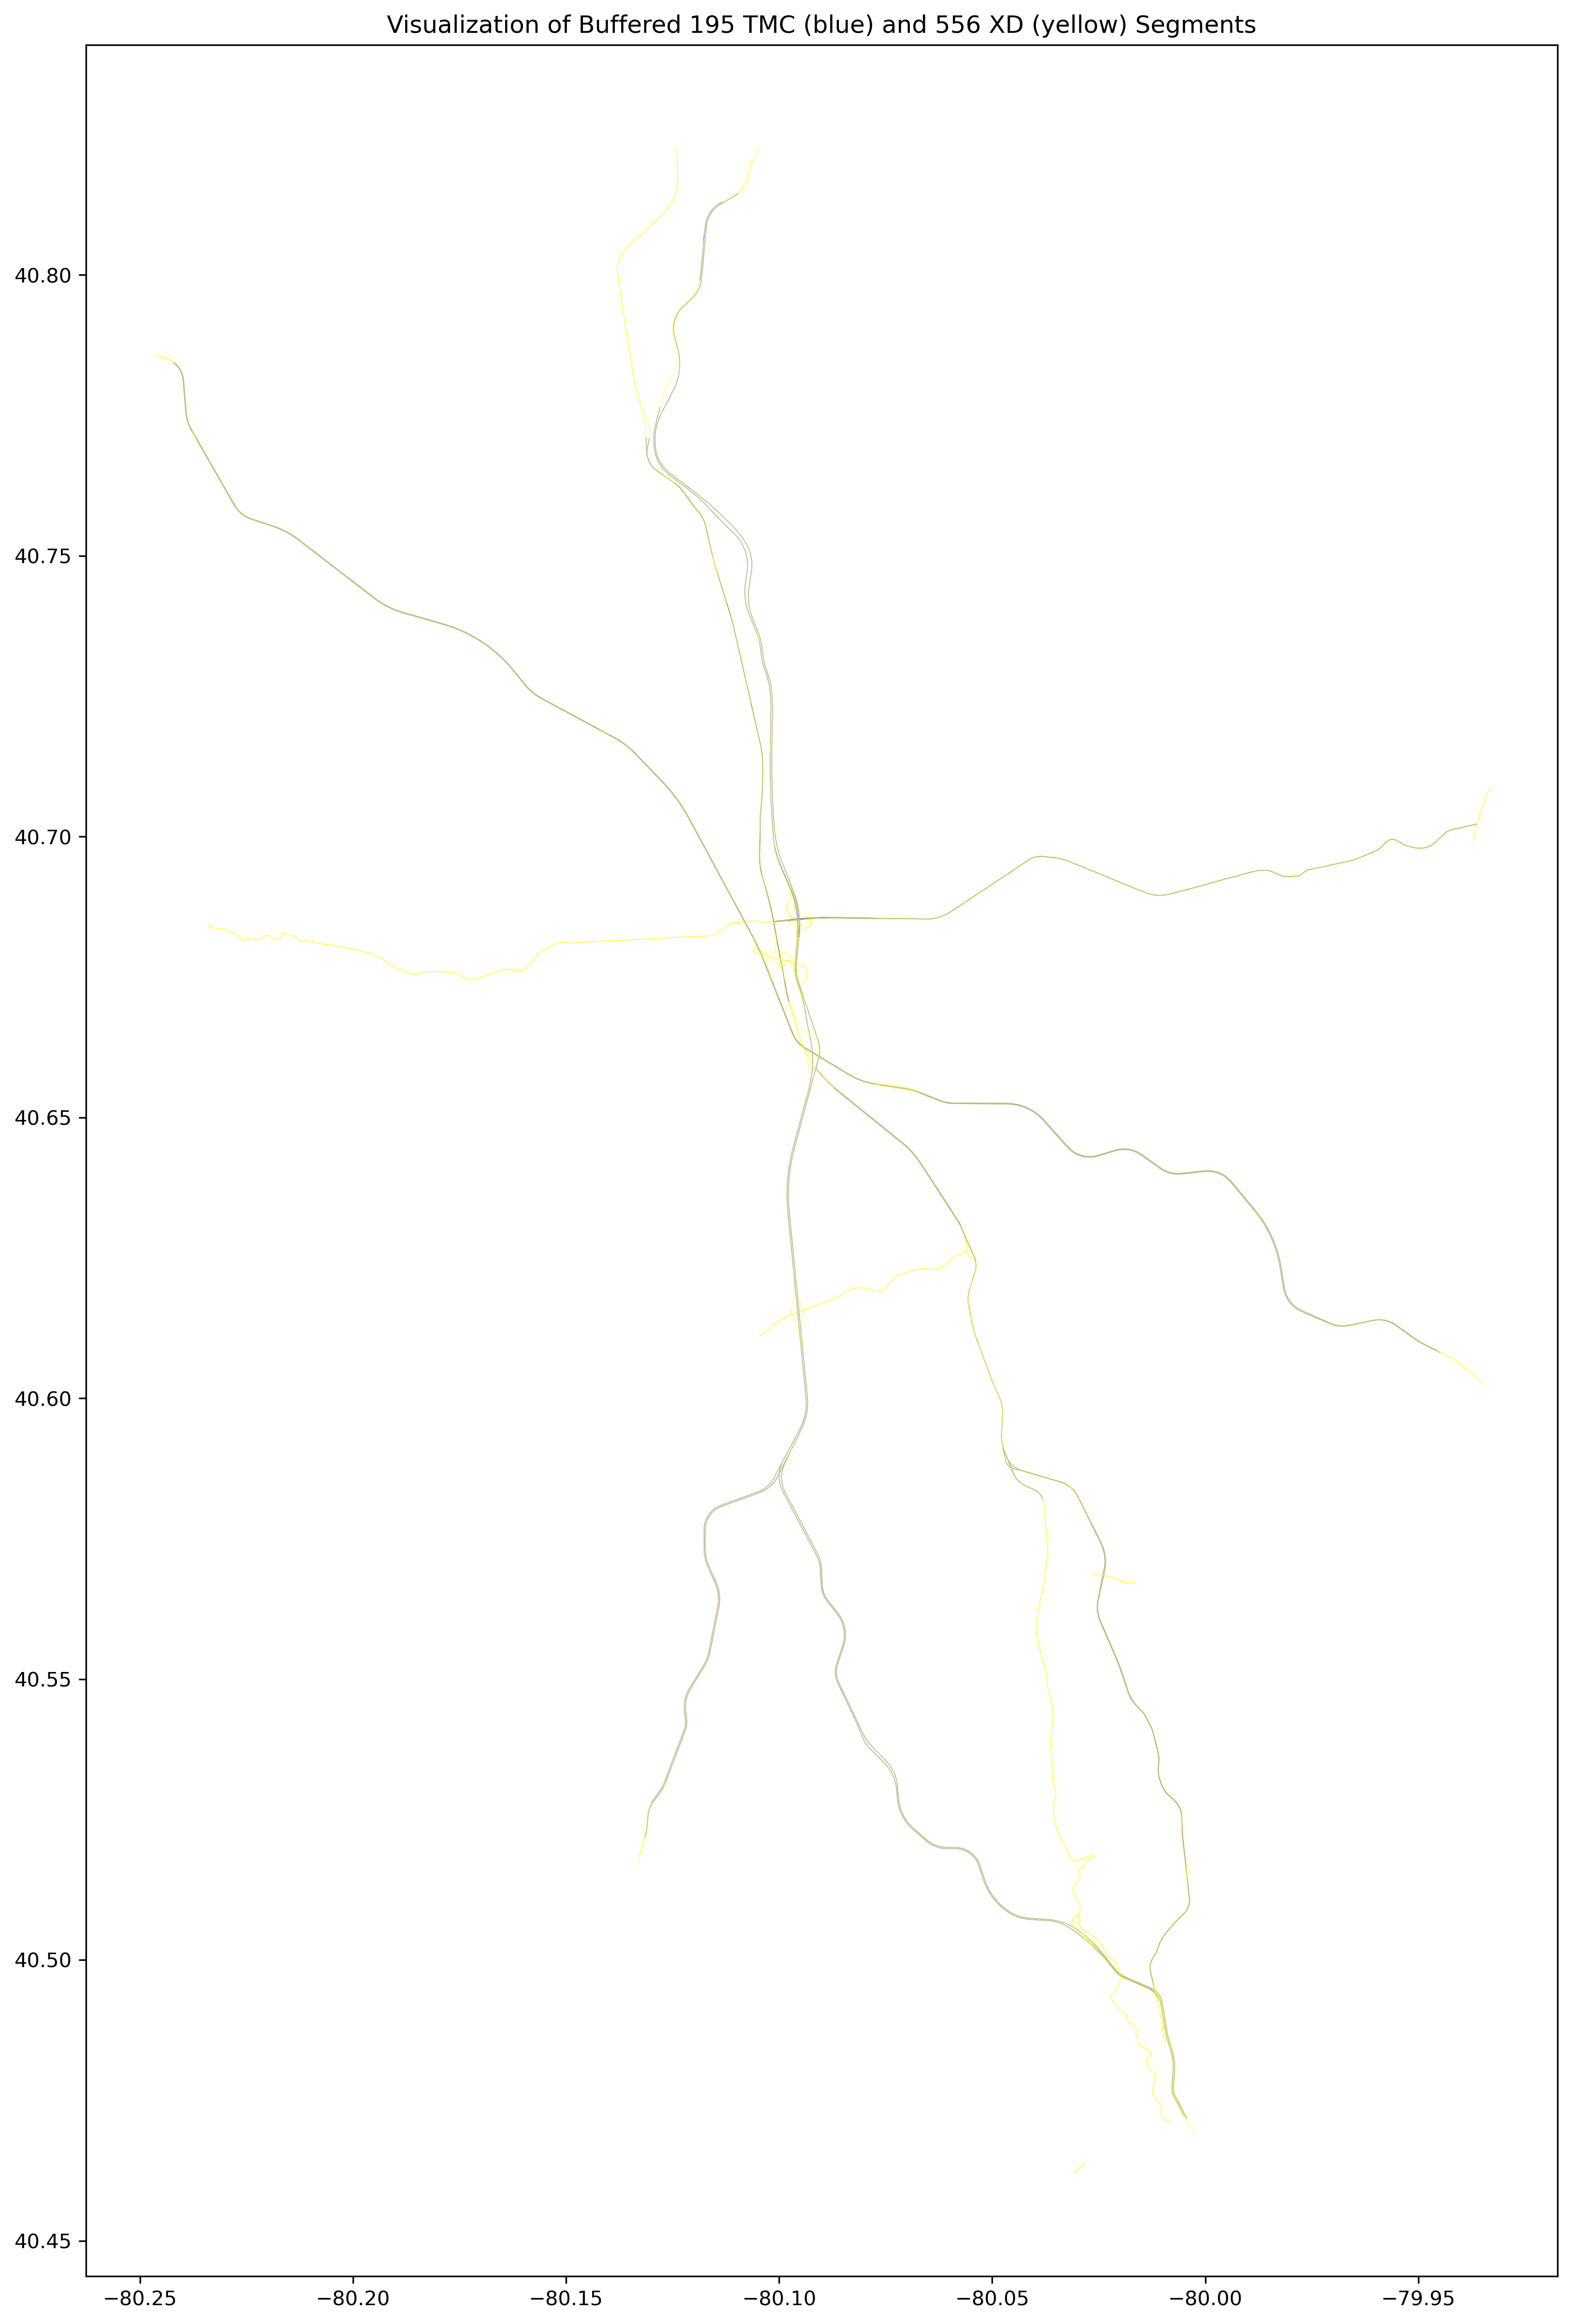

In [16]:
# Visualization of Buffered 195 TMC (blue) and 556 XD (yellow) Segments
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
ax.set_title("Visualization of Buffered 195 TMC (blue) and 556 XD (yellow) Segments")
gpdf_tmc_cranberry_polygon[gpdf_tmc_cranberry_polygon.id.isin(set(spd_tmc.tmc))].plot(ax=ax, color="blue", alpha=0.5)
gpdf_xd_cranberry_polygon.plot(ax=ax, color="yellow", alpha=0.5)
fig.savefig("./viz_buffered_tmc195_xd.jpg")

### 2.2 Spatial Join

In [17]:
# we would like to retain all tmc segments, therefore we do left join here
xd_to_tmc = gpd.sjoin(left_df=gpdf_tmc_cranberry_polygon, right_df=gpdf_xd_cranberry, how="left", op="intersects") # include all 315 tmc ids, 540 xd ids

In [18]:
xd_to_tmc 

,id,geometry,index_right,OID,XDSegID,PreviousXD,NextXDSegI,FRC,RoadNumber,RoadName,...,SlipRoad,SpecialRoa,RoadList,StartLat,StartLong,EndLat,EndLong,Bearing,XDGroup,ShapeSRID
0,104P06676,"POLYGON ((-80.09267 40.68533, -80.09273 40.685...",542,None,1310597390,None,None,0,None,None,...,1,None,None,40.68528,-80.09392,40.68574,-80.09526,W,3612871,4326
0,104P06676,"POLYGON ((-80.09267 40.68533, -80.09273 40.685...",245,None,1310330692,None,1310330704,0,None,None,...,1,None,None,40.6848,-80.09259,40.6854,-80.09267,N,3461167,4326
0,104P06676,"POLYGON ((-80.09267 40.68533, -80.09273 40.685...",541,None,1310597366,429090786,None,0,None,None,...,1,None,None,40.6848,-80.09259,40.68543,-80.0918,N,3612857,4326
0,104P06676,"POLYGON ((-80.09267 40.68533, -80.09273 40.685...",546,None,1310597509,429110245,1310323857,0,228,PA 228,...,0,None,PA 228,40.68508,-80.09725,40.68528,-80.09392,E,514061,4326
0,104P06676,"POLYGON ((-80.09267 40.68533, -80.09273 40.685...",30,None,388051958,None,None,0,228,PA 228,...,0,None,PA 228,40.68528,-80.09392,40.6854,-80.09267,E,1970621,4326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,104+09201,"POLYGON ((-80.03789 40.58170, -80.03789 40.581...",229,None,1310320977,1310319406,1310398365,1,19,US 19,...,0,None,US 19,40.57288,-80.03695,40.56355,-80.03885,S,531444,4326
330,104+09201,"POLYGON ((-80.03789 40.58170, -80.03789 40.581...",227,None,1310319406,1310231548,1310320977,1,19,US 19,...,0,None,US 19,40.58203,-80.03812,40.57238,-80.03693,S,531444,4326
330,104+09201,"POLYGON ((-80.03789 40.58170, -80.03789 40.581...",226,None,1310319396,1310320989,1310231536,1,19,US 19,...,0,None,US 19,40.57238,-80.03693,40.58203,-80.03812,N,474329,4326
330,104+09201,"POLYGON ((-80.03789 40.58170, -80.03789 40.581...",122,None,1310231536,1310319396,1310306645,1,19,US 19,...,0,None,"US 19,Pine Creek Road",40.58203,-80.03812,40.58681,-80.04515,W,474329,4326


In [19]:
# Join with dataframe "spd_tmc", which contains tmc features such as starting and ending latitude and longitude
selected_xd_to_tmc = pd.merge(left=pd.DataFrame(xd_to_tmc), right=spd_tmc, left_on="id", right_on="tmc", how="inner") 

'''
'id', 'geometry', 'index_right', 'OID', 'XDSegID', 'PreviousXD',
       'NextXDSegI', 'FRC', 'RoadNumber', 'RoadName', 'LinearID', 'Country',
       'State', 'County', 'District', 'Miles', 'Lanes', 'SlipRoad',
       'SpecialRoa', 'RoadList', 'StartLat', 'StartLong', 'EndLat', 'EndLong',
       'Bearing', 'XDGroup', 'ShapeSRID', 'tmc', 'road', 'direction',
       'intersection', 'state', 'county', 'zip', 'start_latitude',
       'start_longitude', 'end_latitude', 'end_longitude', 'miles',
       'road_order', 'timezone_name', 'type', 'country', 'tmclinear', 'frc',
       'border_set', 'f_system', 'urban_code', 'faciltype', 'structype',
       'thrulanes', 'route_numb', 'route_sign', 'route_qual', 'altrtename',
       'aadt', 'aadt_singl', 'aadt_combi', 'nhs', 'nhs_pct', 'strhnt_typ',
       'strhnt_pct', 'truck', 'isprimary', 'active_start_date',
       'active_end_date'
'''

"\n'id', 'geometry', 'index_right', 'OID', 'XDSegID', 'PreviousXD',\n       'NextXDSegI', 'FRC', 'RoadNumber', 'RoadName', 'LinearID', 'Country',\n       'State', 'County', 'District', 'Miles', 'Lanes', 'SlipRoad',\n       'SpecialRoa', 'RoadList', 'StartLat', 'StartLong', 'EndLat', 'EndLong',\n       'Bearing', 'XDGroup', 'ShapeSRID', 'tmc', 'road', 'direction',\n       'intersection', 'state', 'county', 'zip', 'start_latitude',\n       'start_longitude', 'end_latitude', 'end_longitude', 'miles',\n       'road_order', 'timezone_name', 'type', 'country', 'tmclinear', 'frc',\n       'border_set', 'f_system', 'urban_code', 'faciltype', 'structype',\n       'thrulanes', 'route_numb', 'route_sign', 'route_qual', 'altrtename',\n       'aadt', 'aadt_singl', 'aadt_combi', 'nhs', 'nhs_pct', 'strhnt_typ',\n       'strhnt_pct', 'truck', 'isprimary', 'active_start_date',\n       'active_end_date'\n"

In [20]:
selected_xd_to_tmc.head(5)

,id,geometry,index_right,OID,XDSegID,PreviousXD,NextXDSegI,FRC,RoadNumber,RoadName,...,aadt_singl,aadt_combi,nhs,nhs_pct,strhnt_typ,strhnt_pct,truck,isprimary,active_start_date,active_end_date
0,104P06676,"POLYGON ((-80.09267 40.68533, -80.09273 40.685...",542,None,1310597390,None,None,0,None,None,...,928,517,1,100,0,100,0,1,2019-01-01 00:00:00-05:00,2020-01-01 00:00:00-05:00
1,104P06676,"POLYGON ((-80.09267 40.68533, -80.09273 40.685...",245,None,1310330692,None,1310330704,0,None,None,...,928,517,1,100,0,100,0,1,2019-01-01 00:00:00-05:00,2020-01-01 00:00:00-05:00
2,104P06676,"POLYGON ((-80.09267 40.68533, -80.09273 40.685...",541,None,1310597366,429090786,None,0,None,None,...,928,517,1,100,0,100,0,1,2019-01-01 00:00:00-05:00,2020-01-01 00:00:00-05:00
3,104P06676,"POLYGON ((-80.09267 40.68533, -80.09273 40.685...",546,None,1310597509,429110245,1310323857,0,228,PA 228,...,928,517,1,100,0,100,0,1,2019-01-01 00:00:00-05:00,2020-01-01 00:00:00-05:00
4,104P06676,"POLYGON ((-80.09267 40.68533, -80.09273 40.685...",30,None,388051958,None,None,0,228,PA 228,...,928,517,1,100,0,100,0,1,2019-01-01 00:00:00-05:00,2020-01-01 00:00:00-05:00


In [21]:
selected_xd_to_tmc = selected_xd_to_tmc[["id", "XDSegID", "PreviousXD", "NextXDSegI", 'StartLat', 'StartLong', 'EndLat', 'EndLong', 'start_latitude', 'start_longitude', 'end_latitude', 'end_longitude']]
selected_xd_to_tmc.columns = ["id_tmc", "id_xd", "prev_xd", "next_xd", 'xd_start_lat', 'xd_start_long', 'xd_end_lat', 'xd_end_long', 'tmc_start_lat', 'tmc_start_long', 'tmc_end_lat', 'tmc_end_long']

In [22]:
selected_xd_to_tmc # 195 tmc ids, 435 xd ids

,id_tmc,id_xd,prev_xd,next_xd,xd_start_lat,xd_start_long,xd_end_lat,xd_end_long,tmc_start_lat,tmc_start_long,tmc_end_lat,tmc_end_long
0,104P06676,1310597390,None,None,40.68528,-80.09392,40.68574,-80.09526,40.68504,-80.09806,40.68545,-80.09178
1,104P06676,1310330692,None,1310330704,40.6848,-80.09259,40.6854,-80.09267,40.68504,-80.09806,40.68545,-80.09178
2,104P06676,1310597366,429090786,None,40.6848,-80.09259,40.68543,-80.0918,40.68504,-80.09806,40.68545,-80.09178
3,104P06676,1310597509,429110245,1310323857,40.68508,-80.09725,40.68528,-80.09392,40.68504,-80.09806,40.68545,-80.09178
4,104P06676,388051958,None,None,40.68528,-80.09392,40.6854,-80.09267,40.68504,-80.09806,40.68545,-80.09178
...,...,...,...,...,...,...,...,...,...,...,...,...
1123,104+04734,1310231536,1310319396,1310306645,40.58203,-80.03812,40.58681,-80.04515,40.58206,-80.03812,40.58765,-80.04555
1124,104+04734,1310231548,1310596331,1310319406,40.58681,-80.04515,40.58203,-80.03812,40.58206,-80.03812,40.58765,-80.04555
1125,104+04734,1310596331,None,1310231548,40.58914,-80.04641,40.58681,-80.04504,40.58206,-80.03812,40.58765,-80.04555
1126,104+04734,1310306645,1310231536,429091253,40.58681,-80.04504,40.58915,-80.04631,40.58206,-80.03812,40.58765,-80.04555


# 3. Checking on Direction

In [244]:
# helper function to compute the angle between two vectors
def angle(xd_start_lat, xd_start_long, tmc_start_lat, tmc_start_long, xd_end_lat, xd_end_long, tmc_end_lat, tmc_end_long):
    v1 = [float(xd_end_long)-float(xd_start_long), float(xd_end_lat)-float(xd_start_lat)]
    v2 = [float(tmc_end_long)-float(tmc_start_long), float(tmc_end_lat)-float(tmc_start_lat)]
    unit_v1 = v1/np.linalg.norm(v1)
    unit_v2 = v2/np.linalg.norm(v2)
    return np.arccos(np.clip(np.dot(unit_v1, unit_v2), -1.0, 1.0))/np.pi

In [245]:
# compute angles between each spatially joined pair of tmc and xd segments
selected_xd_to_tmc["angle"] = selected_xd_to_tmc.apply(lambda x: angle(x.xd_start_lat, x.xd_start_long, x.tmc_start_lat, x.tmc_start_long, x.xd_end_lat, x.xd_end_long, x.tmc_end_lat, x.tmc_end_long), axis=1)

In [246]:
# five number summary of angles between each spatially joined pair of tmc and xd segments
selected_xd_to_tmc["angle"].describe()

count    1.128000e+03
mean     3.367819e-01
std      3.791098e-01
min      4.743187e-09
25%      3.023793e-02
50%      1.185527e-01
75%      7.528848e-01
max      9.999691e-01
Name: angle, dtype: float64

In [247]:
selected_xd_to_tmc

,id_tmc,id_xd,prev_xd,next_xd,xd_start_lat,xd_start_long,xd_end_lat,xd_end_long,tmc_start_lat,tmc_start_long,tmc_end_lat,tmc_end_long,angle
0,104P06676,1310597390,None,None,40.68528,-80.09392,40.68574,-80.09526,40.68504,-80.09806,40.68545,-80.09178,0.873990
1,104P06676,1310330692,None,1310330704,40.6848,-80.09259,40.6854,-80.09267,40.68504,-80.09806,40.68545,-80.09178,0.521441
2,104P06676,1310597366,429090786,None,40.6848,-80.09259,40.68543,-80.0918,40.68504,-80.09806,40.68545,-80.09178,0.193533
3,104P06676,1310597509,429110245,1310323857,40.68508,-80.09725,40.68528,-80.09392,40.68504,-80.09806,40.68545,-80.09178,0.001657
4,104P06676,388051958,None,None,40.68528,-80.09392,40.6854,-80.09267,40.68504,-80.09806,40.68545,-80.09178,0.009712
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,104+04734,1310231536,1310319396,1310306645,40.58203,-80.03812,40.58681,-80.04515,40.58206,-80.03812,40.58765,-80.04555,0.015237
1124,104+04734,1310231548,1310596331,1310319406,40.58681,-80.04515,40.58203,-80.03812,40.58206,-80.03812,40.58765,-80.04555,0.984763
1125,104+04734,1310596331,None,1310231548,40.58914,-80.04641,40.58681,-80.04504,40.58206,-80.03812,40.58765,-80.04555,0.874505
1126,104+04734,1310306645,1310231536,429091253,40.58681,-80.04504,40.58915,-80.04631,40.58206,-80.03812,40.58765,-80.04555,0.136409


In [255]:
raw_final_xd_to_tmc = selected_xd_to_tmc[selected_xd_to_tmc.angle < 0.5] # 195 tmc id, 428 xd ids, shape (774, 13)

In [257]:
raw_final_xd_to_tmc

,id_tmc,id_xd,prev_xd,next_xd,xd_start_lat,xd_start_long,xd_end_lat,xd_end_long,tmc_start_lat,tmc_start_long,tmc_end_lat,tmc_end_long,angle
2,104P06676,1310597366,429090786,None,40.6848,-80.09259,40.68543,-80.0918,40.68504,-80.09806,40.68545,-80.09178,0.193533
3,104P06676,1310597509,429110245,1310323857,40.68508,-80.09725,40.68528,-80.09392,40.68504,-80.09806,40.68545,-80.09178,0.001657
4,104P06676,388051958,None,None,40.68528,-80.09392,40.6854,-80.09267,40.68504,-80.09806,40.68545,-80.09178,0.009712
5,104P06676,1310323857,1310597509,429090769,40.68528,-80.09392,40.6854,-80.09267,40.68504,-80.09806,40.68545,-80.09178,0.009712
6,104P06676,429090769,1310323857,1310290990,40.6854,-80.09267,40.68543,-80.0918,40.68504,-80.09806,40.68545,-80.09178,0.009780
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119,104+04532,1310380359,1310330296,1310368732,40.52001,-80.05861,40.52134,-80.06528,40.51985,-80.05697,40.52160,-80.06568,0.000465
1120,104+04532,1310498302,None,None,40.52134,-80.06528,40.52989,-80.0721,40.51985,-80.05697,40.52160,-80.06568,0.222564
1122,104+04734,1310319396,1310320989,1310231536,40.57238,-80.03693,40.58203,-80.03812,40.58206,-80.03812,40.58765,-80.04555,0.255632
1123,104+04734,1310231536,1310319396,1310306645,40.58203,-80.03812,40.58681,-80.04515,40.58206,-80.03812,40.58765,-80.04555,0.015237


In [256]:
len(raw_final_xd_to_tmc.id_tmc.unique()), len(raw_final_xd_to_tmc.id_xd.unique())

(195, 428)

In [258]:
raw_final_xd_to_tmc[raw_final_xd_to_tmc.id_tmc == '104P06676']

,id_tmc,id_xd,prev_xd,next_xd,xd_start_lat,xd_start_long,xd_end_lat,xd_end_long,tmc_start_lat,tmc_start_long,tmc_end_lat,tmc_end_long,angle
2,104P06676,1310597366,429090786,None,40.6848,-80.09259,40.68543,-80.0918,40.68504,-80.09806,40.68545,-80.09178,0.193533
3,104P06676,1310597509,429110245,1310323857,40.68508,-80.09725,40.68528,-80.09392,40.68504,-80.09806,40.68545,-80.09178,0.001657
4,104P06676,388051958,None,None,40.68528,-80.09392,40.6854,-80.09267,40.68504,-80.09806,40.68545,-80.09178,0.009712
5,104P06676,1310323857,1310597509,429090769,40.68528,-80.09392,40.6854,-80.09267,40.68504,-80.09806,40.68545,-80.09178,0.009712
6,104P06676,429090769,1310323857,1310290990,40.6854,-80.09267,40.68543,-80.0918,40.68504,-80.09806,40.68545,-80.09178,0.009780
7,104P06676,1310290990,429090769,1310291096,40.68543,-80.0918,40.68542,-80.07496,40.68504,-80.09806,40.68545,-80.09178,0.020941
9,104P06676,1310597378,1310573080,1310392300,40.6819,-80.09532,40.68574,-80.09526,40.68504,-80.09806,40.68545,-80.09178,0.474275
11,104P06676,1310334146,1310597497,1310323271,40.68677,-80.09629,40.68241,-80.09592,40.68504,-80.09806,40.68545,-80.09178,0.493804
13,104P06676,1310597301,1310457035,None,40.68526,-80.09727,40.68508,-80.09725,40.68504,-80.09806,40.68545,-80.09178,0.485529
14,104P06676,1310597509,429110245,1310323857,40.68508,-80.09725,40.68528,-80.09392,40.68504,-80.09806,40.68545,-80.09178,0.001657


In [259]:
raw_final_xd_to_tmc.to_csv("../../data/raw_xd_to_tmc.csv", index=False) # need further checking on QGIS (step 4 below)

# 4. Manual Checking on QGIS
- This step involves manual checking and comparison, and is completed on QGIS
- The final tmc-xd matching result has been saved in "../../data/xd_to_tmc_v2.xlsx" and "../../data/xd_to_tmc_v2.csv"

# 5. Save Final Result as Dictionary

In [23]:
final_xd_to_tmc = pd.read_csv("../../data/xd_to_tmc_v2.csv")

In [24]:
final_xd_to_tmc # 195 tmc matched with 396 xd, shape (612, 14)
# actually, final_xd_to_tmc is equivalent to final_tmc_to_xd

,id_tmc,id_xd,prev_xd,next_xd,xd_start_lat,xd_start_long,xd_end_lat,xd_end_long,tmc_start_lat,tmc_start_long,tmc_end_lat,tmc_end_long,angle,Note
0,104-04438,1310464502,1.310271e+09,1.310465e+09,40.53322,-80.12616,40.52754,-80.13033,40.54885,-80.12067,40.53283,-80.12633,0.093476,NaN
1,104-04438,1310270724,1.310271e+09,1.310465e+09,40.54020,-80.12266,40.53322,-80.12616,40.54885,-80.12067,40.53283,-80.12633,0.039844,NaN
2,104-04438,1310270733,1.310569e+09,1.310271e+09,40.54852,-80.12094,40.54020,-80.12266,40.54885,-80.12067,40.53283,-80.12633,0.043214,NaN
3,104-04438,1310569369,1.310271e+09,1.310271e+09,40.55586,-80.11625,40.54852,-80.12094,40.54885,-80.12067,40.53283,-80.12633,0.072880,NaN
4,104-04439,1310569369,1.310271e+09,1.310271e+09,40.55586,-80.11625,40.54852,-80.12094,40.58853,-80.09930,40.55586,-80.11625,0.028643,末端碰头、无重叠
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,104P13682,1310495688,1.310496e+09,1.310496e+09,40.62578,-79.98291,40.63340,-79.98817,40.62981,-79.98502,40.63030,-79.98538,0.009376,TMC segment相对于XD segment而言太小了
608,104P13683,1310495826,4.291158e+08,1.310496e+09,40.64419,-80.01688,40.64312,-80.02804,40.64311,-80.02804,40.64323,-80.02882,0.079016,末端碰头、无重叠
609,104P13683,1310495840,1.310496e+09,1.310496e+09,40.64312,-80.02804,40.64854,-80.03660,40.64311,-80.02804,40.64323,-80.02882,0.131083,TMC segment相对于XD segment而言太小了
610,104P13684,1310499806,1.310500e+09,1.310500e+09,40.77916,-80.23949,40.78573,-80.24612,40.78410,-80.24147,40.78440,-80.24190,0.054650,TMC segment相对于XD segment而言太小了


In [25]:
final_dict_xd_to_tmc = final_xd_to_tmc.groupby("id_tmc").apply(lambda x: x.id_xd.tolist()).to_dict()
final_dict_tmc_to_xd = final_xd_to_tmc.groupby("id_xd").apply(lambda x: x.id_tmc.tolist()).to_dict()

In [311]:
with open("../../data/xd_to_tmc_v2.pkl", "wb") as f1, open("../../data/tmc_to_xd_v2.pkl", "wb") as f2:
    pickle.dump(final_dict_xd_to_tmc, f1)
    pickle.dump(final_dict_tmc_to_xd, f2)

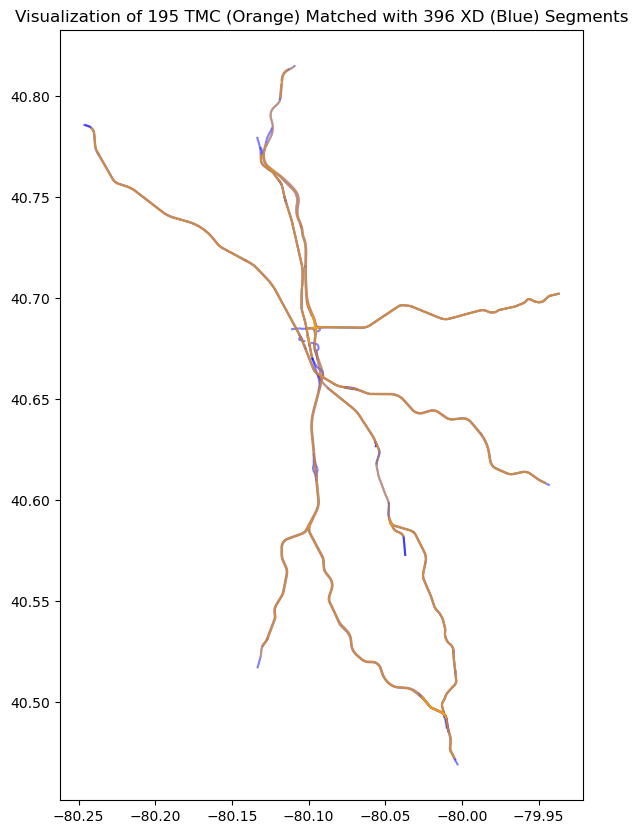

In [47]:
# Visualization of Matched 195 TMC (blue) and 396 XD (yellow) Segments (Buffered with radius 10)
fig, ax = plt.subplots(1,figsize=(15,10))
ax.set_title("Visualization of 195 TMC (Orange) Matched with 396 XD (Blue) Segments")
gpdf_xd_cranberry[gpdf_xd_cranberry.XDSegID.astype(int).isin(set(final_xd_to_tmc.id_xd))].plot(ax=ax, color="blue", alpha=0.5)
gpdf_tmc_cranberry[gpdf_tmc_cranberry.id.isin(set(final_xd_to_tmc.id_tmc))].plot(ax=ax, color="orange", alpha=0.5)
fig.savefig("./viz_final_xd_to_tmc195.jpg")